# Create Statistical Index Model for Predicting Landslide Probabilities

## Package Import, Working Directory and Functions

In [7]:
# package import
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from mapclassify import JenksCaspall
from scipy.ndimage import generic_filter

In [ ]:
# set working environment
work_dir = "/local/path/to/GEO403_landslide_susceptibility_analysis"
os.chdir(work_dir)

In [9]:
def load_raster(file_path, target_nodata=-9999):
    """
    Load raster data and replace NoData values.
    Args:
        file_path (str): Path to the raster file
        target_nodata (int/float): Value to replace NoData pixels with
    Returns:
        data (np.array): Raster data
        transform (Affine): Transformation matrix
        crs (CRS): Coordinate Reference System
        metadata (dict): Original metadata for possible export
    """ 
    with rasterio.open(file_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        metadata = src.meta.copy()
        nodata = src.nodatavals[0]

        # convert to float32 if target_nodata is negative
        if target_nodata < 0:
            data = data.astype(np.float32)

        # replace nodata values
        if nodata is not None:
            data[data == nodata] = target_nodata

        return data, transform, crs, metadata
    

def compute_flow_accumulation(dem):
    """
    Computes flow accumulation using a basic neighborhood approach (not true hydrological routing).
    Args:
        dem (np.array): Digital Elevation Model (DEM)
    Returns:
        flow_accum (np.array): Flow accumulation
    """
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])

    # count pixels lower than center
    flow_accum = generic_filter(dem, lambda x: np.sum(x < x[4]), footprint=kernel, mode="nearest")
    
    # ensure no zeros (avoiding log issues later)
    flow_accum[flow_accum == 0] = 1
    
    # multiply by cell size (30x30m)
    flow_accum = flow_accum * 900 

    return flow_accum


def compute_twi(slope, flow_accum):
    """
    Computes Topographic Wetness Index (TWI) from slope and flow accumulation.
    Args:
        slope (np.array): Slope in degrees
        flow_accum (np.array): Flow accumulation
    Returns:
        twi (np.array): Topographic Wetness Index (TWI)
    """
    # convert slope from degrees to radians
    slope_radians = np.tan(np.radians(slope))

    # prevent division by zero or very small values
    slope_radians = np.maximum(slope_radians, np.finfo(float).eps)
    
    # compute TWI
    twi = np.log(flow_accum / slope_radians)
    
    return twi


def categorize_raster(data, bins, nodata_value=-9999):
    """
    categorizes raster data based on given bins and categories.
    Args:
        data (np.array): rasterdata as NumPy-Array.
        bins (list): categorie borders.
        nodata_value (int): NaN Value to keel.
    Returns:
        categorized_data (np.array): categorized rasters.
    """
    categorized_data = np.full_like(data, nodata_value, dtype=np.int32)
    valid_mask = (data != -9999) & (~np.isnan(data))  
    categorized_data[valid_mask] = np.digitize(data[valid_mask], bins, right=True)

    return categorized_data


def plot_landslide_distribution(categorized_rasters, landslide_raster, name_dict, label_dict, save_plots=False):
    """
    Create barplots for the distribution of landslides per category.
    Args:
        categorized_rasters (dict): Dictionary with categorized raster array
        landslide_raster (np.array): Raster-Array with landslide-labels (1 = Landslide, 0 = No Landslide)
        name_dict (dict): Dictonary containing display names for rasters
        label_dict (dict): Dictonary containing class labels for rasters
    """
    # create figure with A4 size and subplots in a 2-column layout
    fig, axes = plt.subplots(nrows=len(categorized_rasters) // 2 + len(categorized_rasters) % 2, ncols=2, figsize=(15, 21.21))
    axes = axes.flatten()
    
    # loop through categorized rasters
    for idx, (var_name, raster) in enumerate(categorized_rasters.items()):
        # ignore no data
        unique_classes = np.unique(raster[raster != -9999])
        
        # determine absolute/relative landslide counts per class
        landslide_counts = [np.sum((raster == category) & (landslide_raster == 1)) for category in unique_classes]
        total_landslides = np.sum(landslide_counts)
        landslides_relativ = [(counts / total_landslides) * 100 if total_landslides > 0 else 0 for counts in landslide_counts]
        
        # create barplot
        ax = axes[idx]
        sns.barplot(x=unique_classes, y=landslides_relativ, palette="viridis", hue=unique_classes, ax=ax)
        
        # use dict names for raster names in title
        ax.set_title(f"Hangrutschungsverteilung für {name_dict[var_name]}", fontsize=12, pad=20.0)
        
        # plot labels from label dict for classes
        ax.set_xticks(range(len(unique_classes)))
        ax.set_xticklabels([label_dict[var_name][str(int(cat))] for cat in unique_classes], rotation=45, ha="right", fontsize=10)
        
        # set axis labels
        #ax.set_xlabel(name_dict[var_name], fontsize=10)
        ax.set_ylabel("Hangrutschungsdichte [%]", fontsize=10)
        
        # remove legend
        ax.get_legend().remove()
        
        # make top x and right y axis invisible
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # add value labels to bars
        for i, v in enumerate(landslide_counts):
            ax.text(i, landslides_relativ[i] + 0.5, str(v), color='black', ha='center')
        

    # adjust layout for better spacing
    plt.subplots_adjust(hspace=0.9, wspace=0.3)
    
    # save or show figure
    if save_plots:
        plt.savefig("landslide_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()


def compute_si_with_viewmask(categorized_rasters, landslide_raster, view_mask):
    """
    Calculates Statistical Index (SI), within the viewmask.
    
    Args:
        categorized_rasters (dict): Dictionary with categorized raster arrays
        landslide_raster (np.array): Raster-Array with landslide labels (1 = landslide, 0 = no landslide)
        view_mask (np.array): Mask Raster with 1 for visible pixels, NaN for invisible pixels

    Returns:
        pd.DataFrame: DataFrame with SI-Values for every category of every variable.
    """
    # create results list
    results = []
    
    # apply mask to landslide raster
    masked_landslide = np.where(view_mask == 1, landslide_raster, np.nan)
    
    # total amount of landslide pixels in view mask
    total_landslide_pixels = np.nansum(masked_landslide == 1)
    
    # total amount of visible pixels
    total_pixels = np.nansum(view_mask == 1)

    for var_name, raster in categorized_rasters.items():
        # ignore no data
        masked_raster = np.where(view_mask == 1, raster, np.nan)
        unique_classes = np.unique(masked_raster[~np.isnan(masked_raster)])
        
        for category in unique_classes:
            # per class pixelcount
            N_pix_Ni = np.nansum(masked_raster == category)
            
            # slide count per class
            N_pix_Li = np.nansum((masked_raster == category) & (masked_landslide == 1))
            
            # calculate SI, densclass and densmap
            if N_pix_Ni > 0 and total_landslide_pixels > 0:
                Densclass = N_pix_Li / N_pix_Ni
                Densmap = total_landslide_pixels / total_pixels
                SI = np.log(Densclass / Densmap) if Densclass > 0 else -9999  # avoid log(0)
            else:
                # set no data for categories with no landslides
                SI = -9999

            # append result to list
            results.append({"Variable": var_name, "Category": category, "SI": SI})

    # return as dataframe
    return pd.DataFrame(results)


def compute_weighting_factor(si_results, categorized_rasters, landslide_raster):
    """
    Calculates Weighting Factor (WF) based on SI values.
    Args:
        si_results (pd.DataFrame): DataFrame with SI values for every category of every variable
        categorized_rasters (dict): Dictionary with categorized raster arrays
        landslide_raster (np.array): Raster-Array with landslide labels (1 = landslide, 0 = no landslide)
    Returns:
        pd.DataFrame: Dataframe with Weighting Factors for every variable
    """
    # create result list/dict
    wf_results = []
    ts_values = {}

    # loop through SI results
    for var_name, group in si_results.groupby("Variable"):
        ts_sum = 0  # Sum for TS_i
        
        # loop through rows
        for _, row in group.iterrows():
            category = row["Category"]
            si_value = row["SI"] if not np.isnan(row["SI"]) else 0

            # calculate number of pixels in category with landslide
            N_pix_Li = np.count_nonzero((categorized_rasters[var_name] == category) & (landslide_raster == 1))

            # calculate TS_i
            ts_i = N_pix_Li * si_value
            ts_sum += ts_i

        # write sum to dict
        ts_values[var_name] = ts_sum

    # min-max scaling of TS_i values
    min_ts = min(ts_values.values())
    max_ts = max(ts_values.values())

    # loop through dict items
    for var_name, ts_i in ts_values.items():
        # prevent division by zero
        if max_ts == min_ts:
            wf = 1
        else:
            wf = ((ts_i - min_ts) / (max_ts - min_ts)) * 9 + 1  # scale [1, 10]

        # append to result list
        wf_results.append({"Variable": var_name, "Weighting Factor": wf})

    # return as dataframe
    return pd.DataFrame(wf_results)


def preprocess_rasters(categorized_rasters):
    """
    Preprocesses raster data by converting NoData values (-9999) to NaN and ensuring consistent dtype (float32).
    Args:
        categorized_rasters (dict): Dictionary with categorized raster arrays
    Returns:
        dict: Dictionary with cleaned raster arrays.
    """
    # create result dict
    cleaned_rasters = {}
    
    # loop through rasters
    for key, raster in categorized_rasters.items():
        # write to 32float
        raster_cleaned = raster.astype(np.float32)

        # set nan
        raster_cleaned[raster_cleaned == -9999] = np.nan  # NoData to NaN
        cleaned_rasters[key] = raster_cleaned
    
    return cleaned_rasters


def compute_lsm(wf_results, si_results, categorized_rasters):
    """
    Calculates Landslide Susceptibility Model (LSM) with weighting factors and SI values. Ignores NoData values.
    Args:
        wf_results (pd.DataFrame): Weighting Factors for each variable
        si_results (pd.DataFrame): SI-Values for each category of each variable
        categorized_rasters (dict): Dictionary with categorized raster arrays
    Returns:
        np.array: LSM as NumPy-Array.
    """
    # initialize LSM with zeros
    lsm = np.zeros_like(next(iter(categorized_rasters.values())), dtype=np.float32)

    # loop through weighting factors
    for _, row in wf_results.iterrows():
        var_name = row["Variable"]
        wf_value = row["Weighting Factor"]

        if var_name in categorized_rasters:
            raster = categorized_rasters[var_name]
            
            # set nan as -9999
            raster[np.isnan(raster)] = -9999
            
            print(f"Processing Variable: {var_name} (Raster dtype: {raster.dtype})")

            # loop through current variables rows
            for _, si_row in si_results[si_results["Variable"] == var_name].iterrows():
                # ensure data type consistency
                category = np.float32(si_row["Category"])
                si_value = si_row["SI"]

                # ignore nodata values
                if np.isnan(si_value):  
                    continue

                # ensure category matching works properly
                mask = np.isclose(raster, category)  
                matched_pixels = np.sum(mask)

                print(f"  Category: {category}, SI: {si_value}, WF: {wf_value}, Matched Pixels: {matched_pixels}")

                # apply formula if more than zero pixels
                if matched_pixels > 0:
                    lsm[mask] += si_value * wf_value  # Apply formula

    print("LSM Unique Values:", np.unique(lsm))
    return lsm


def classify_lsm(lsm_raster, si_min_possible, si_max_possible):
    """
    Classifies LSM raster based on min and max possible SI values.
    Args:
        lsm_raster (np.array): Calculated LSM raster
        si_min_possible (float): Lowest possible SI value
        si_max_possible (float): Highest possible SI value
    Returns:
        classified_lsm (np.array): Classified LSM raster
    """
    # compute 1% step size
    si_range = si_max_possible - si_min_possible
    si_step = si_range / 100

    # convert LSM values to percentage scale
    si_percent = (lsm_raster - si_min_possible) / si_step  

    # define fixed classification bins based on absolute % scale (6 = very low, 1 = extreme high)
    bins = [0, 20, 40, 60, 80, 97, 100]
    labels = [6, 5, 4, 3, 2, 1]

    # apply classification
    classified_indices = np.digitize(si_percent, bins, right=True)

    # ensure indices are within the valid range (subtract 1 for zero-based indexing)
    classified_lsm = np.where(
        np.isnan(si_percent),
        np.nan,
        np.array(labels)[np.clip(classified_indices - 1, 0, len(labels) - 1)]
    )
    
    return classified_lsm

## Load Raster Files

In [10]:
# set raster file paths
raster_files = {
    "landcover": "created/aligned_rasters/landcover.tif", # landcover classes 
    "litho": "created/aligned_rasters/litho.tif", # litho classes
    "landslides": "created/aligned_rasters/landslides.tif", # 1 - NAN 
    "precipitation": "created/aligned_rasters/precipitation.tif", # continuous values
    "road_distance": "created/aligned_rasters/road_distance.tif", # distance classes
    "soil": "created/aligned_rasters/soil.tif", # soil classes
    "view_mask": "created/aligned_rasters/view_mask.tif", # bool mask
    "water": "created/aligned_rasters/water_distance.tif", # distance classes
    "aspect": "created/aligned_rasters/aspect.tif", # continuous values
    "dem": "created/dem.tif", # continuous values
    "slope": "created/aligned_rasters/slope.tif" # continuous values
}

# load raster data and save metadata
rasters = {}
transforms = {}
crs_dict = {}
metadata_dict = {}

for key, file_path in raster_files.items():
    rasters[key], transforms[key], crs_dict[key], metadata_dict[key] = load_raster(file_path)
    print(f"Loaded raster {key}, Shape: {rasters[key].shape}")

# check if crs is the same for all rasters
unique_crs = set(crs_dict.values())
if len(unique_crs) > 1:
    print("Warning: Multiple CRS detected!")
else:
    print(f"Unique CRS: {list(unique_crs)[0]}")

Loaded raster landcover, Shape: (4838, 5486)
Loaded raster litho, Shape: (4838, 5486)
Loaded raster landslides, Shape: (4838, 5486)
Loaded raster precipitation, Shape: (4838, 5486)
Loaded raster road_distance, Shape: (4838, 5486)
Loaded raster soil, Shape: (4838, 5486)
Loaded raster view_mask, Shape: (4838, 5486)
Loaded raster water, Shape: (4838, 5486)
Loaded raster aspect, Shape: (4838, 5486)
Loaded raster dem, Shape: (4838, 5486)
Loaded raster slope, Shape: (4838, 5486)
Unique CRS: EPSG:32648


## Calculate Topographic Wetness Index

In [11]:
# TWI save path/load path
twi_raster_path = "created/aligned_rasters/twi.tif"
dem_path = raster_files["dem"]
slope_raster_path = raster_files["slope"]

# check if twi raster already exists
if os.path.exists(twi_raster_path):
    print("Found existing TWI raster. Loading...")
else:
    print("TWI raster not found. Calculating...")

    # load DEM
    with rasterio.open(dem_path) as src:
        dem = src.read(1).astype(np.float32)
        transform = src.transform
        crs = src.crs
        nodata = src.nodata if src.nodata is not None else -9999

    # nodata to nan
    dem[dem == nodata] = np.nan

    # load slope 
    with rasterio.open(slope_raster_path) as src:
        slope = src.read(1).astype(np.float32)
        transform = src.transform
        crs = src.crs
        nodata = src.nodata if src.nodata is not None else -9999

    # nodata to nan
    slope[slope == nodata] = np.nan

    # calc flow accumulation    
    flow_accum = compute_flow_accumulation(dem)

    # calc twi
    twi = compute_twi(slope, flow_accum)

    # reset nodata values
    twi[np.isnan(dem)] = nodata

    # save TWI raster
    with rasterio.open(
        twi_raster_path, "w", driver="GTiff",
        height=twi.shape[0], width=twi.shape[1],
        count=1, dtype=twi.dtype, crs=crs, transform=transform,
        nodata=nodata
    ) as dst:
        dst.write(twi, 1)

    print(f"TWI raster saved at: <{twi_raster_path}>")

# load TWI raster and add to rasters dict
twi, transform, crs, metadata = load_raster(twi_raster_path)
rasters["twi"] = twi
transforms["twi"] = transform
crs_dict["twi"] = crs
metadata_dict["twi"] = metadata
print("Done.")

Found existing TWI raster. Loading...
Done.


## Categorize Variables

### Find Natural Breaks in Precipitation Raster

In [12]:
# flatten precipitation raster for classification
precip_values = rasters["precipitation"].flatten()

# remove nan values
precip_values = precip_values[~np.isnan(precip_values)]

# determine number of bins (classes)
num_classes = 6

# compute optimal bin boundaries using Jenks Natural Breaks
classifier = JenksCaspall(precip_values, k=num_classes)
adaptive_bins = classifier.bins

# ensures bins are a list of float values
adaptive_bins_list = adaptive_bins.tolist()

# number of precipitation categories
num_categories = len(adaptive_bins_list)

slope done.
aspect done.
dem done.
twi done.
water done.
precipitation done.


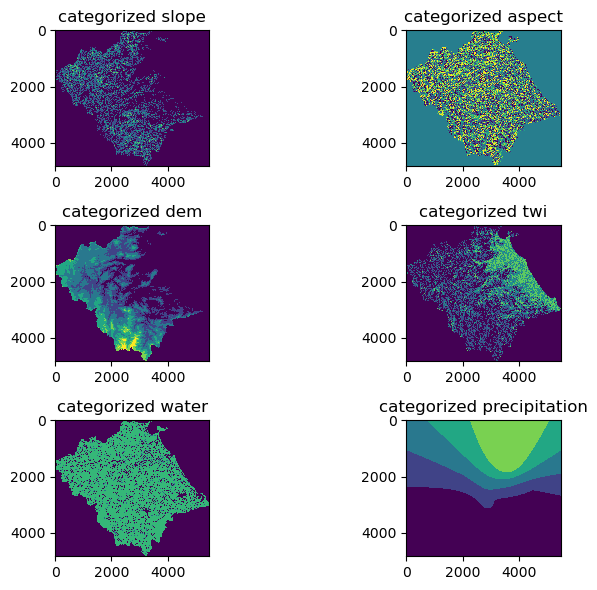

In [24]:
# categorization rules based on Meinhardt et al. (2015)
categorization_rules = {
    "slope": {
        "bins": [10, 20, 30, 40, 70],
        "categories": [1, 2, 3, 4, 5]
    },
    "aspect": {
        "bins": [-np.pi - 1e-6, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi + 1e-6],
        "categories": [1, 2, 3, 4, 5, 6, 7, 8]  
    },
    "dem": { # instead of valley depth
        "bins": [-1, 200, 500, 1000, 1500, 2000, 2700],
        "categories": [1, 2, 3, 4, 5, 6]
    },
    "twi": {
       "bins": [8, 9, 10, 12, 46],  # twi bins
     "categories": [1, 2, 3, 4, 5]
    },
    "water": {  # water classes
        "bins": [30, 60, 90],  # categories: <30, 30-60, 60-90, >90
        "categories": [1, 2, 3, 4]
    },
    "precipitation": {  # precipitation classes (Adaptive)
        "bins": adaptive_bins_list,  
        "categories": list(range(1, num_categories + 1))  # categories start from 1
    }
}
# nan value
nodata_value = -9999

# categorize rasters
categorized_rasters = {}
for key, rules in categorization_rules.items():
    if key in rasters:
        categorized_rasters[key] = categorize_raster(
            rasters[key], rules["bins"], nodata_value
        )
        print(f"{key} done.")

# visualize categorized rasters
fig, axes = plt.subplots(3, 2, figsize=(8, 6))
axes = axes.flatten()
for i, key in enumerate(categorized_rasters.keys()):
    ax = axes[i]
    ax.imshow(categorized_rasters[key], cmap="viridis", vmin=1, vmax=len(categorization_rules[key]["categories"]), interpolation="none")
    ax.set_title(f"categorized {key}")
plt.tight_layout()
plt.show()

In [25]:
# add litho, landcover, road distance and soil to categorized rasters
categorized_rasters["litho"] = rasters["litho"]
categorized_rasters["landcover"] = rasters["landcover"]
categorized_rasters["road_distance"] = rasters["road_distance"]
categorized_rasters["soil"] = rasters["soil"]

# apply nan mask from dem raster to be sure
mask = rasters["dem"] == -9999
for key in categorized_rasters:
    categorized_rasters[key][mask] = -9999

# write complete categorized_rasters dict to pickle file
cat_raster_pkl_path = "created/categorized_rasters.pkl"
with open(cat_raster_pkl_path, "wb") as dst:
   pickle.dump(categorized_rasters, dst)


## Plot Landslide Distributions per Variable and Class

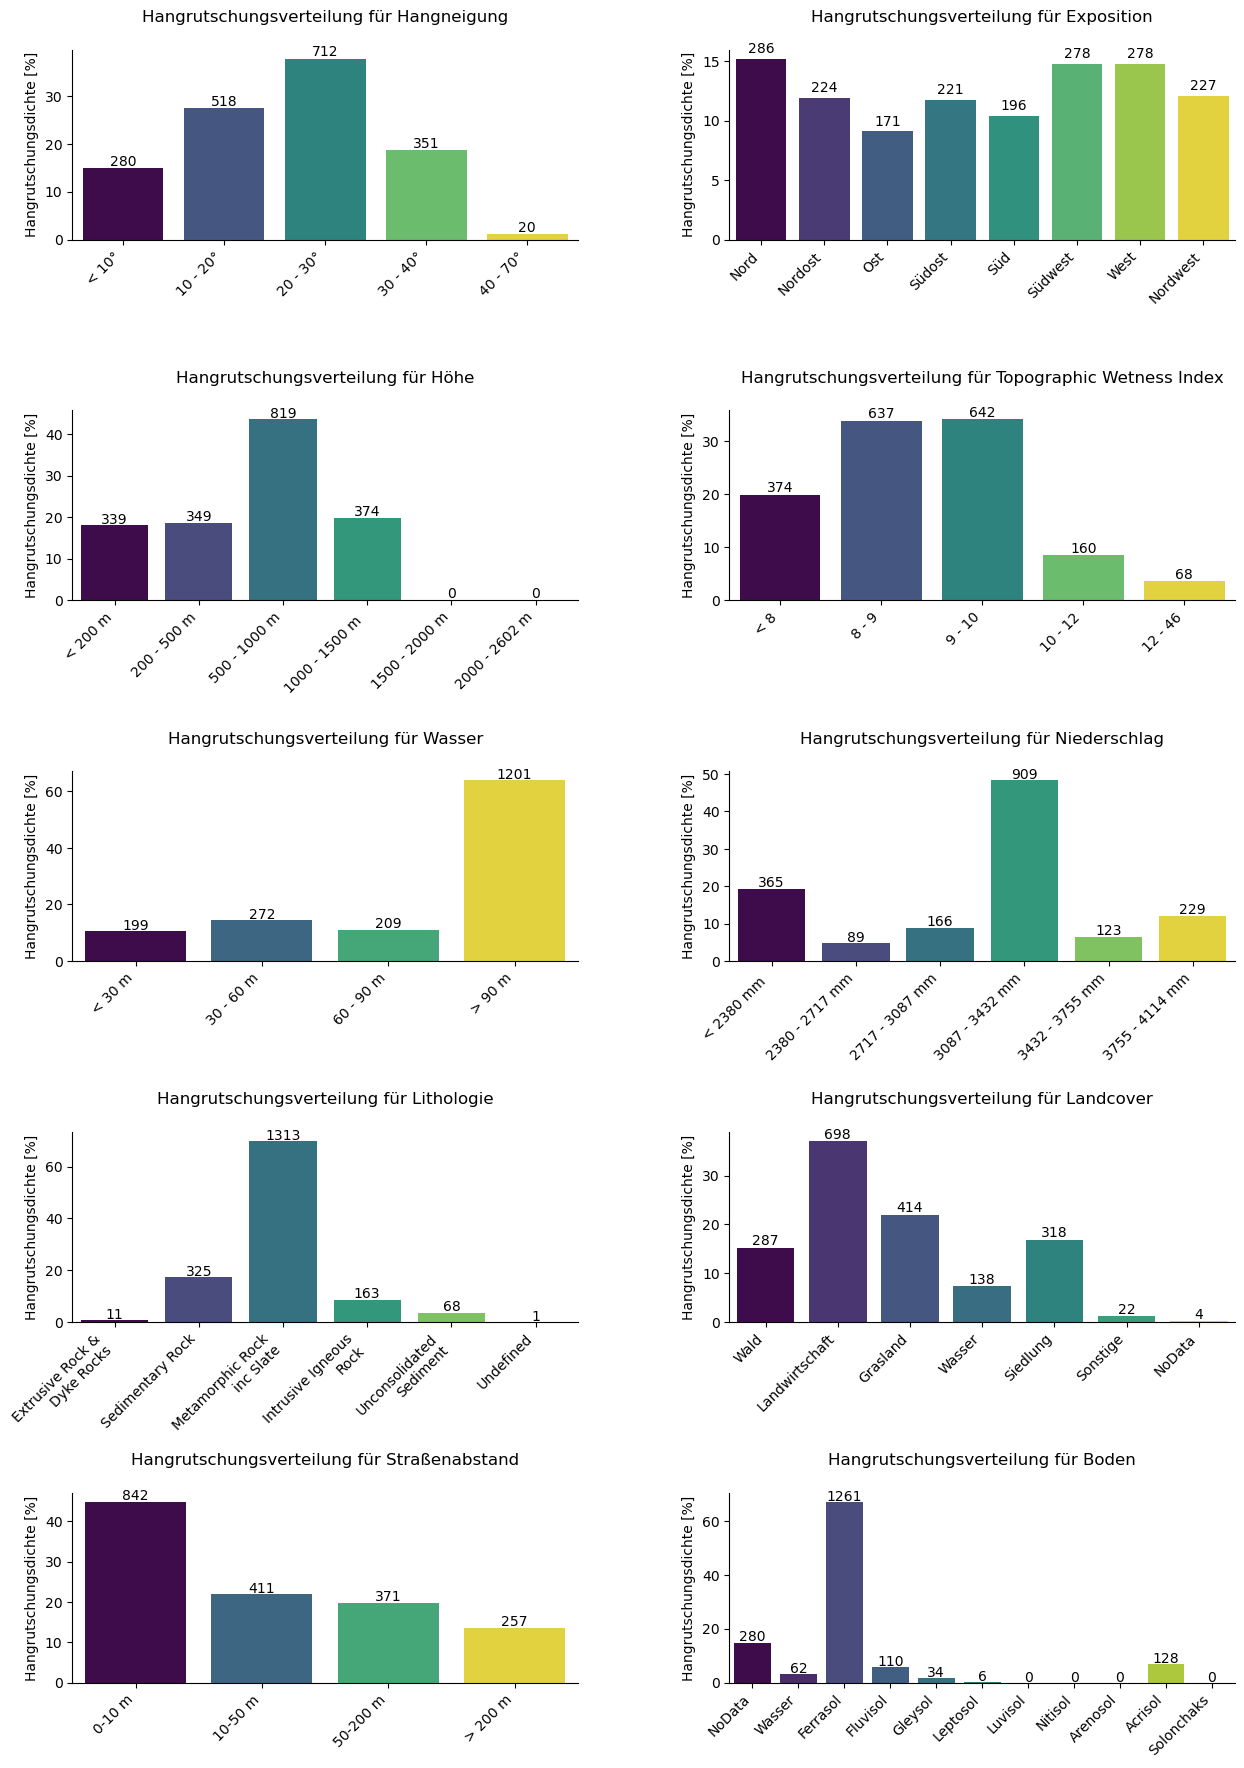

In [26]:
# create name dict for rasters
name_dict = {
    "landcover": "Landcover",
    "litho": "Lithologie",
    "landslides": "Rutschungen",
    "precipitation": "Niederschlag",
    "road_distance": "Straßenabstand",
    "soil": "Boden",
    "view_mask": "Sichtbarkeit",
    "water": "Wasser",
    "aspect": "Exposition",
    "dem": "Höhe",
    "slope": "Hangneigung",
    "twi": "Topographic Wetness Index",
}


# list of label dicts: 
label_dict = {
    "landcover": {"1":"Wald","2": "Landwirtschaft", "3": "Grasland", "4": "Wasser", "5": "Siedlung", "6": "Sonstige", "9": "NoData"}, 
    "litho": {"1": "Extrusive Rock &\nDyke Rocks", "2": "Sedimentary Rock", "3": "Metamorphic Rock\ninc Slate", "4": "Intrusive Igneous\nRock", "5" : "Unconsolidated\nSediment", "6": "Undefined" },
    # from classification
    "precipitation": {"0": "< 2380 mm ", "1": "2380 - 2717 mm", "2": "2717 - 3087 mm", "3": "3087 - 3432 mm", "4": "3432 - 3755 mm", "5": "3755 - 4114 mm"},
    "road_distance": {"1": "0-10 m", "2": "10-50 m", "3": "50-200 m", "4": "> 200 m"},
    "soil": {"1": "NoData", "2": "Wasser", "3": "Ferrasol", "4" : "Fluvisol", "5": "Gleysol", "6": "Leptosol", "7": "Luvisol", "8":"Nitisol", "9": "Arenosol", "10": "Acrisol", "11": "Solonchaks"},
    "water": {"0": "< 30 m", "1": "30 - 60 m", "2": "60 - 90 m", "3": "> 90 m"},
    "aspect": {"1" : "Nord", "2": "Nordost", "3": "Ost", "4" : "Südost", "5": "Süd", "6" : "Südwest", "7": "West", "8": "Nordwest",},
    "dem": {"1" : "< 200 m", "2": "200 - 500 m", "3": "500 - 1000 m", "4" : "1000 - 1500 m ", "5": "1500 - 2000 m", "6": "2000 - 2602 m",},
    "slope": {"0" : "< 10°", "1": "10 - 20°", "2": "20 - 30°", "3" : "30 - 40°", "4": "40 - 70°", "5": "> 70°",},
    "twi": {"0" : "< 8", "1": "8 - 9", "2": "9 - 10", "3" : "10 - 12", "4": "12 - 46",},
}

# plot landslide distribution
plot_landslide_distribution(categorized_rasters, rasters["landslides"], name_dict, label_dict, save_plots=False)


## Statistical Index

In [27]:
# calculate statistical index (SI) with view mask
view_mask = rasters["view_mask"]
si_results_viewmasked = compute_si_with_viewmask(categorized_rasters, rasters["landslides"], view_mask)

# get lowest SI besides -9999 to fill nan values
min_si = si_results_viewmasked[si_results_viewmasked["SI"] != -9999]["SI"].min()

# replace -9999 with min SI
si_results_viewmasked.replace({"SI": {-9999: min_si}}, inplace=True)

# drop all rows with category -9999
si_results_viewmasked_no_nan = si_results_viewmasked[si_results_viewmasked["Category"] != -9999.0]

## Weighting Factor

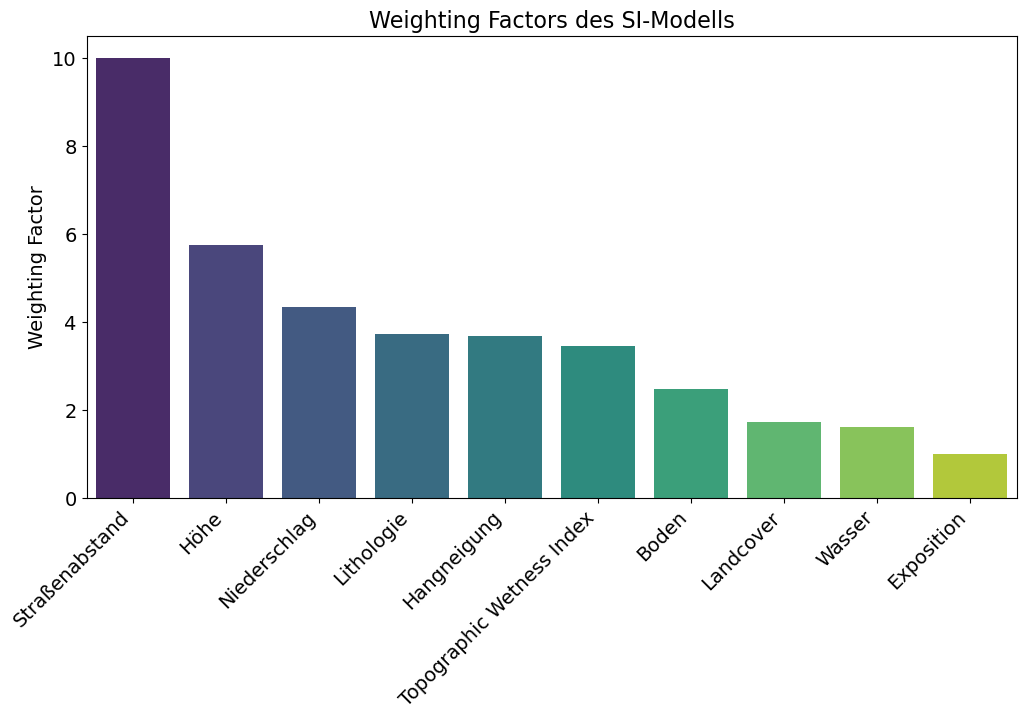

In [28]:
# weighting factor berechnen
wf_results = compute_weighting_factor(si_results_viewmasked, categorized_rasters, rasters["landslides"])

# rename df_results columns based on name_dict
wf_results_de = wf_results.copy()
wf_results_de["Variable"] = wf_results["Variable"].map(name_dict)

# sort by weighting factor 
wf_results_de = wf_results_de.sort_values(by="Weighting Factor", ascending=False)

# plot weighting factor results barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=wf_results_de, x="Variable", y="Weighting Factor", palette="viridis", hue="Variable")
plt.title("Weighting Factors des SI-Modells", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("", fontsize=14)

plt.ylabel("Weighting Factor", fontsize=14)
plt.show()

## Create Landslide Suceptibility Map

In [29]:
# preprocess raster files 
cleaned_rasters = preprocess_rasters(categorized_rasters)

# calculate lsm raster
lsm_raster_cleaned = compute_lsm(wf_results, si_results_viewmasked_no_nan, cleaned_rasters)

# set 0 to nan 
lsm_raster_cleaned[lsm_raster_cleaned == 0] = np.nan

Processing Variable: aspect (Raster dtype: float32)
  Category: 1.0, SI: 0.15760061375947074, WF: 1.0, Matched Pixels: 1833506
  Category: 2.0, SI: -0.07386311650807172, WF: 1.0, Matched Pixels: 1862345
  Category: 3.0, SI: -0.21436007868738266, WF: 1.0, Matched Pixels: 1639597
  Category: 4.0, SI: -0.3291107381684813, WF: 1.0, Matched Pixels: 1915653
  Category: 5.0, SI: -0.0014229379844913955, WF: 1.0, Matched Pixels: 1560755
  Category: 6.0, SI: 0.2501963347850219, WF: 1.0, Matched Pixels: 1625617
  Category: 7.0, SI: 0.15031244242938802, WF: 1.0, Matched Pixels: 1672741
  Category: 8.0, SI: 0.010749392136855265, WF: 1.0, Matched Pixels: 1639371
Processing Variable: dem (Raster dtype: float32)
  Category: 1.0, SI: -1.1124941321116728, WF: 5.7445045788855005, Matched Pixels: 4736833
  Category: 2.0, SI: -0.2752634500096401, WF: 5.7445045788855005, Matched Pixels: 3165215
  Category: 3.0, SI: 1.0263064758213785, WF: 5.7445045788855005, Matched Pixels: 3794942
  Category: 4.0, SI: 1.35

In [30]:
# save lsm raster as GeoTIFF
lsm_raster_path = "created/predictions/SI_landslide_susceptibility_map.tif"

with rasterio.open(
    lsm_raster_path, "w", driver="GTiff",
    height=lsm_raster_cleaned.shape[0], width=lsm_raster_cleaned.shape[1],
    count=1, dtype=lsm_raster_cleaned.dtype, crs=crs, transform=transform,
    nodata=-9999
) as dst:
    dst.write(lsm_raster_cleaned, 1)

## Classify Landslide Suceptibility Map

### Calculate highest and lowest possible SI values

In [31]:
# merge SI DataFrame with Weighting Factors
si_results_weighted = si_results_viewmasked_no_nan.merge(wf_results, on="Variable", how="left")

# apply Weighting Factor to SI values
si_results_weighted["SI_weighted"] = si_results_weighted["SI"] * si_results_weighted["Weighting Factor"]

# compute the min/max possible weighted SI
si_min_per_var = si_results_weighted.groupby("Variable")["SI_weighted"].min()
si_max_per_var = si_results_weighted.groupby("Variable")["SI_weighted"].max()

# get total min/max SI across all variables (sum of min/max per variable)
si_min_possible = si_min_per_var.sum()
si_max_possible = si_max_per_var.sum()

si_results_weighted

,Variable,Category,SI,Weighting Factor,SI_weighted
0,slope,0.0,-1.181660,3.679396,-4.347794
1,slope,1.0,0.263897,3.679396,0.970983
2,slope,2.0,0.580177,3.679396,2.134702
3,slope,3.0,0.814690,3.679396,2.997566
4,slope,4.0,0.197309,3.679396,0.725978
...,...,...,...,...,...
56,soil,7.0,-2.005538,2.462666,-4.938970
57,soil,8.0,-2.005538,2.462666,-4.938970
58,soil,9.0,-2.005538,2.462666,-4.938970
59,soil,10.0,0.015723,2.462666,0.038720


In [32]:
# run classification using absolute SI scale
classified_lsm = classify_lsm(lsm_raster_cleaned, si_min_possible, si_max_possible)

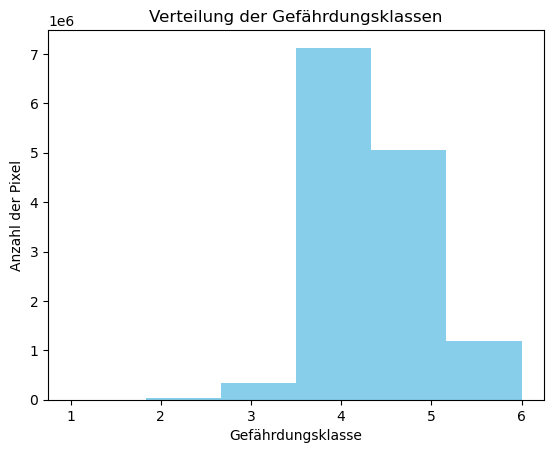

{1.0: 13,
 2.0: 31123,
 3.0: 342450,
 4.0: 7124742,
 5.0: 5062504,
 6.0: 1188753,
 nan: 12791683}

In [33]:
# histogram of classified_lsm
plt.hist(classified_lsm.flatten(), bins=6, color="skyblue")
plt.title("Verteilung der Gefährdungsklassen")
plt.xlabel("Gefährdungsklasse")
plt.ylabel("Anzahl der Pixel")
plt.show()

# amount of pixel per class
unique_classes, counts = np.unique(classified_lsm, return_counts=True)
class_counts = dict(zip(unique_classes, counts))
class_counts


In [34]:
# convert classes to int
classified_lsm_int = np.where(np.isnan(classified_lsm), -9999, classified_lsm).astype(np.int32)

# save classified lsm raster as GeoTIFF
classified_lsm_raster_path = "created/predictions/SI_landslide_susceptibility_map_classified.tif"

with rasterio.open(
    classified_lsm_raster_path, "w", driver="GTiff",
    height=classified_lsm.shape[0], width=classified_lsm.shape[1],
    count=1, dtype=rasterio.int32,
    crs=crs, transform=transform,
    nodata=-9999
) as dst:
    dst.write(classified_lsm_int, 1)
